In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Distribution of round-off errors

We can investigate what round-off errors look like by picking a bunch of random float64 values, recasting them as float32, and looking at the difference. This tells us the distribution of errors in float32 relative to the "right answer." Of course there are similar errors in float32 values, but of course much smaller.

Note we have to assume we are picking good random numbers. We'll talk later about how random numbers are actually generated.

In [2]:
values_64 = np.random.random(size=100000)
values_32 = np.float32(values_64)
diff = np.float64(values_32) - values_64

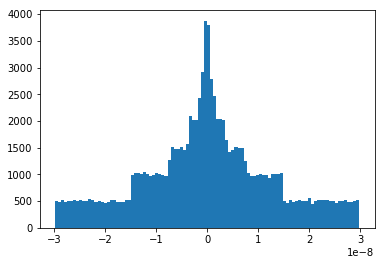

In [3]:
hist = plt.hist(diff, bins=100)

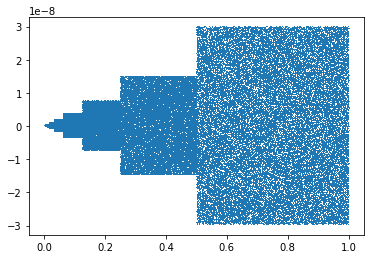

In [4]:
plt.plot(values_64, diff, ',')

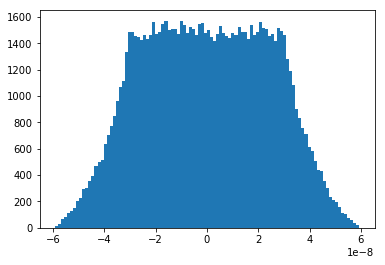

In [5]:
hist = plt.hist(diff / values_64, bins=100)

## Round-off vs. approximation errors

In [6]:
def fnc_int(limits=None):
    return ((limits[1]**3 - limits[0]**3) / 3. - 
            (limits[1]**4 - limits[0]**4) / 4. + 
            (limits[1]**5 - limits[0]**5) / 5.)

In [7]:
def fnc(x=None):
    return (x**2 - x**3 + x**4)

In [8]:
def integrate_fnc(limits=None, nstep=None, fnc=None, dtype=None):
    instep = 1. / np.float64(nstep).astype(dtype)
    step = (limits[1] - limits[0]) * instep 
    middles = limits[0] + (np.arange(nstep, dtype=dtype) + 0.5) * instep * (limits[1] - limits[0])
    values = fnc(middles)
    return (values.sum() * step)

In [9]:
dtype = np.float32

In [10]:
def test_integrate(dtype=None):
    limits = np.array([1., 2.], dtype=dtype)
    nstep_low = 10
    nstep_high = 100000000
    nnsteps = 50
    nsteps = 10.**(np.log10(nstep_low) +
                   (np.log10(nstep_high) - np.log10(nstep_low)) * np.arange(nnsteps) /
                   np.float64(nnsteps - 1))
    nsteps = np.int64(nsteps)
    error = np.zeros(nnsteps, dtype=np.float64)
    for indx in np.arange(nnsteps):
        integral = fnc_int(limits=np.float64(limits))
        approx = integrate_fnc(limits=limits, nstep=nsteps[indx], fnc=fnc, dtype=dtype)
        error[indx] = (approx - integral) / integral
    return(nsteps, error)

In [11]:
(nsteps64, error64) = test_integrate(dtype=np.float64)
(nsteps32, error32) = test_integrate(dtype=np.float32)

/Users/blanton/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/blanton/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


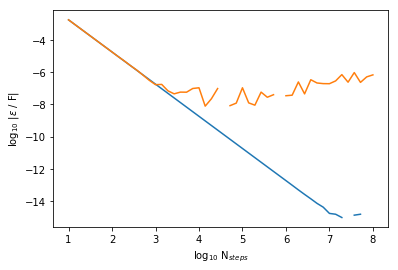

In [12]:
plt.plot(np.log10(nsteps64), np.log10(np.abs(error64)))
plt.plot(np.log10(nsteps32), np.log10(np.abs(error32)))
plt.ylabel('log$_{10}$ |$\epsilon$ / F|')
plt.xlabel('log$_{10}$ N$_{steps}$')